In [82]:
import os
import time
import warnings
warnings.filterwarnings('ignore')

In [83]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [84]:
from utils_image import BatchFeeder

### Set all the Parameters

#### Indicate whether the gpu is available

In [85]:
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

False

In [114]:
# hyperparameters for learning
# train your srcnn with epoch much larger than 100
# 100 is just a demo for 
epoch = 100           
batch_size = 100
learning_rate = 1e-5

In [87]:
# hyperparameters for convolutions
patch_side = 29  # patch size should be (patch_side, patch_side)
c_dim = 3        # dimension of image color

In [88]:
# working directory of 'Spring2019-Proj3-grp1'
pwd = os.path.dirname(os.path.dirname(os.getcwd()))
    
# set the working directory of output
checkpoint_wd = os.path.join(pwd, "output", "checkpoint")
if not os.path.exists(checkpoint_wd):
    os.makedirs(checkpoint_wd)

### Step 0 - Prepare the Data

#### load and patchofy the image data

In [8]:
# loading and bicubic the original image data
# it takes about 6 minutes for the first time (On Linux VM) and 1 minutes afterwards
tic = time.clock()
bf = BatchFeeder()
toc = time.clock()
toc-tic

Loading the training images...
Loading the testing data...


67.12425413498916

#### patchify the row ressolution image

In [13]:
# RUN THIS IF YOU WANT TO RETRAIN THE MODEL 
# it takes about 10 minutes
tic = time.clock()
bf.patch_image()
toc = time.clock()
toc-tic

Patchify the training images...


642.4652449465439

### Step 1 - Creating the Model

#### Placeholders

In [89]:
# images are training data set
lr = tf.placeholder(tf.float32, [None, None, None, c_dim], name='lr')
hr = tf.placeholder(tf.float32, [None, None, None, c_dim], name='hr')

#### Parameters

In [90]:
W1 = tf.Variable(tf.random_normal([9, 9, 3, 64], stddev=1e-3), name='W1')
b1 = tf.Variable(tf.zeros([64]), name='b1')
W2 = tf.Variable(tf.random_normal([1, 1, 64, 32], stddev=1e-3), name='W2')
b2 = tf.Variable(tf.zeros([32]), name='b2')
W3 = tf.Variable(tf.random_normal([5, 5, 32, 3], stddev=1e-3), name='W3')
b3 = tf.Variable(tf.zeros([1]), name='b3')

#### Layers

In [91]:
# patch extraction and representation
conv1 = tf.nn.relu(tf.nn.conv2d(lr, W1, strides=[1,1,1,1], padding='SAME') + b1)
# non-linear mapping
conv2 = tf.nn.relu(tf.nn.conv2d(conv1, W2, strides=[1,1,1,1], padding='SAME') + b2)
# reconstruction
hr_pred = tf.nn.sigmoid(tf.nn.conv2d(conv2, W3, strides=[1,1,1,1], padding='SAME') + b3)

#### Loss Functions

In [92]:
# the higher psnr is, the better the result
# therefore, we define the loss as the negative of psnr
loss = - tf.reduce_mean(tf.image.psnr(hr_pred, hr, max_val=1))

#### Optimizer

In [93]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train = optimizer.minimize(loss)

#### Initializer

In [94]:
init = tf.global_variables_initializer()

### Step 2 - Training the Model

#### Model Output

In [129]:
test_psnr = []
train_psnr = []
pred_image_hr = np.zeros_like(bf.test_lr)

In [130]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

#### Graph Session

In [131]:
tic = time.clock()

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    if os.path.exists(os.path.join(checkpoint_wd, "model_trained.ckpt.meta")):
        saver.restore(sess, os.path.join(checkpoint_wd, "model_trained.ckpt"))

    for i in range(epoch):
        batch = bf.next_batch(batch_size)
        sess.run(train, feed_dict={lr: batch[0], hr: batch[1]})
        
        # PRINT OUT A MESSAGE EVERY 200 STEPS
        if i%20 == 0:
            
            train_p = -sess.run(loss, feed_dict={lr:batch[0], hr:batch[1]})
            train_psnr.append(train_p)
            test_p = -sess.run(loss, feed_dict={lr:bf.test_lr, hr:bf.test_hr})
            test_psnr.append(test_p)
            
            print('Currently on step {}'.format(i))
            print('Training  PSNR is {} '.format(train_p))
            print('Testing PSNR is {} '.format(test_p))
            print('\n')

    save_path = saver.save(sess, os.path.join(checkpoint_wd, "model.ckpt"))
    
toc = time.clock()
toc-tic

INFO:tensorflow:Restoring parameters from C:\Users\sheng\OneDrive\CU Second Semester\Applied Data Science\Spring2019-Proj3-grp1\output\checkpoint\model_trained.ckpt
Currently on step 0
Training  PSNR is 28.914794921875 
Testing PSNR is 25.145402908325195 


Currently on step 20
Training  PSNR is 27.116296768188477 
Testing PSNR is 25.30306053161621 


Currently on step 40
Training  PSNR is 24.265827178955078 
Testing PSNR is 25.304834365844727 


Currently on step 60
Training  PSNR is 26.528797149658203 
Testing PSNR is 25.30619239807129 


Currently on step 80
Training  PSNR is 23.470338821411133 
Testing PSNR is 25.30784034729004 




125.85062083834418

#### The full training history

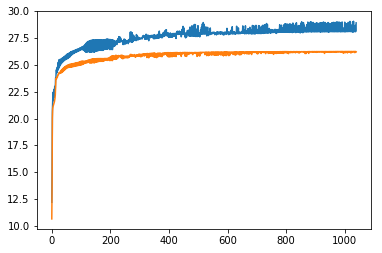

In [133]:
plt.plot(np.load(os.path.join(checkpoint_wd, "train_psnr_trained.npy")))
plt.plot(np.load(os.path.join(checkpoint_wd, "test_psnr_trained.npy")))

### Step 3 - Prediction

In [141]:
pred_image_hr = np.zeros_like(bf.test_image_lr)

In [152]:
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    if os.path.exists(os.path.join(checkpoint_wd, "model.ckpt.meta")):
        saver.restore(sess, os.path.join(checkpoint_wd, "model.ckpt"))
        
    tic = time.clock()
    for i in range(len(pred_image_hr)):
        pred_image_hr[i] = np.squeeze(sess.run(hr_pred, feed_dict={lr:np.expand_dims(bf.test_image_lr[i], axis=0)}))
    toc = time.clock()
    
    print(toc-tic)

INFO:tensorflow:Restoring parameters from C:\Users\sheng\OneDrive\CU Second Semester\Applied Data Science\Spring2019-Proj3-grp1\output\checkpoint\model.ckpt
7.826835848341034


#### Bicubic

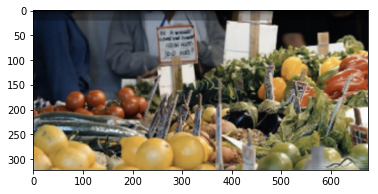

In [161]:
plt.imshow(bf.test_image_lr[5])

#### Our result

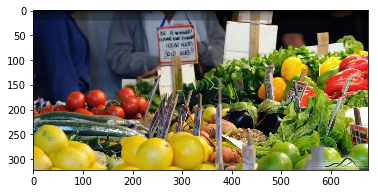

In [159]:
plt.imshow(bf.test_image_hr[5])

#### High resolution picture

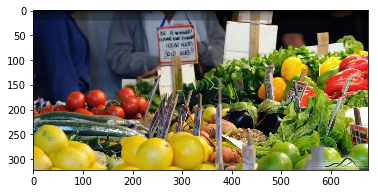

In [163]:
plt.imshow(bf.test_image_hr[5])